In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib import colors as mcolors


from IPython.display import display, Markdown, Latex
import csv
import random
from scipy.cluster.hierarchy import dendrogram

import csv

import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from numpy import linalg as LA
from sklearn.metrics.pairwise import pairwise_distances
from anytree import Node, LevelOrderIter, LevelOrderGroupIter
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA

In [6]:


def get_dist_sample(pos1_list, pos2_list, measure=np.min):
    items = list(itertools.product(pos1_list, pos2_list))
    dists = [
        np.linalg.norm(pos1-pos2)
        for pos1, pos2 in items
    ]
     
    return measure(dists)

def get_dist(node1, node2, measure=np.min):
    pos1_list = get_node_pos(node1)
    pos2_list = get_node_pos(node2)

    items = list(itertools.product(pos1_list, pos2_list))
    dists = [
        np.linalg.norm(pos1-pos2)
        for pos1, pos2 in items
    ]
    return measure(dists)



class Tree():
    def __init__(self, X, measure=np.min):
        self.nodes = [Node(str(id), id=id, leaf=id, pos=pos, dist=None) for id, pos in enumerate(X)]
        self.cs = [i for i, x in enumerate(X)]
        self.leafs = [id for id, pos in enumerate(X)]
        self.D = len(X[0])
        self.Z = []
        self.leaf_dists = pairwise_distances(X)
        self.measure = measure
        
    @property
    def head(self):
        return self.nodes[::-1][0]   
    
    def get_node(self, id):
        return list(filter(lambda node: node.id==id, self.nodes))[0] 
        #return [node.pos for node in nodes]
    def get_leafs(self, node):
        if node.is_leaf:
            return [node]
        return list(filter(lambda children: children.is_leaf, node.descendants))


    def get_dist(self, node1, node2):
        return self.leaf_dists[node1_id, node2_id]
    
    def get_sample_dist(self, node1, node2):
        leafs_1 = [leaf.id for leaf in self.get_leafs(node1)]
        leafs_2 = [leaf.id for leaf in self.get_leafs(node2)]

        items = list(itertools.product(leafs_1, leafs_2))
        dists = [
            self.leaf_dists[leaf_1, leaf_2]
            for leaf_1, leaf_2 in items
        ]
        
        return self.measure(dists)
    

    def add_parent(self, id, id_parent):
        i = list(filter(lambda node: node[1].id==id, enumerate(self.nodes)))[0][0]
        i_parent = list(filter(lambda node: node[1].id==id_parent, enumerate(self.nodes)))[0][0]

        self.nodes[i].parent = self.nodes[i_parent]
        
    def add_link(self, nodei, nodej, dist):
        samplei = len(self.get_leafs(nodei))
        samplei = 1 if samplei ==0 else samplei
        samplej = len(self.get_leafs(nodej))
        samplej = 1 if samplej ==0 else samplej
        samples = samplei + samplej
        z = [float(nodei.id), float(nodej.id), dist, float(samples)]
        self.Z.append(z)
        

   
    
    def get_level(self, max_level):
        return [
            [node for node in children] 
            for children in LevelOrderGroupIter(self.head, maxlevel=max_level)
        ][::-1][0]

    def get_leafs_by_level(self, max_level):
        
        nodes_level = self.get_level(max_level)
        nodes = []
        groups = []
        i_group = 0
        leafs = self.leafs.copy()
        for node in nodes_level:
            childrens_by_node = self.get_leafs(node)
            for children in childrens_by_node:
                nodes.append(children)
                groups.append(i_group)
                leafs.remove(children.id)
            i_group += 1
        for leaf in leafs:
            nodes.append(self.nodes[leaf])
            groups.append(i_group)
            i_group +=1
        return nodes, groups
    
    
    


In [7]:
def get_algomeration(X, measure=np.min):
    tree = Tree(X, measure)
    l=len(tree.cs)
    while len(tree.cs) > 1:
    #for l in range(49):
        #dist = pairwise_distances(x0)
        dist=[]
        for i in range(len(tree.cs)):
            for j in range(i+1,len(tree.cs)):
                nodei = tree.get_node(tree.cs[i])
                nodej = tree.get_node(tree.cs[j])
                item = {
                    "left":nodei,
                    "right":nodej,
                     "dist":tree.get_sample_dist(nodei, nodej)
                }
                dist.append(item)

        i_min = np.argmin([item["dist"] for item in dist])
        nodei = dist[i_min]["left"]
        nodej = dist[i_min]["right"]
        ci_pos = nodei.pos
        cj_pos = nodej.pos
        pos_cluster = (ci_pos + cj_pos)/tree.D

        new_cluster =Node(
            (str(l)),
            id=l, 
            leaf="",
            pos=pos_cluster, 
            dist=dist[i_min]["dist"]) 
        tree.nodes.append(new_cluster)
        tree.add_parent(nodei.id, new_cluster.id)
        tree.add_parent(nodej.id, new_cluster.id)
        tree.add_link(nodei, nodej, dist[i_min]["dist"])


        tree.cs = [c for c in tree.cs if c!=nodei.id and c!=nodej.id]
        
        tree.cs.append(new_cluster.id)
        l+=1
    return tree

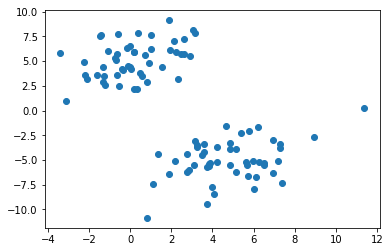

In [8]:
np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([5, -5], [[3, 1], [1, 4]], size=[50,])
b = np.random.multivariate_normal([0, 5], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
plt.scatter(X[:,0], X[:,1])
plt.show()

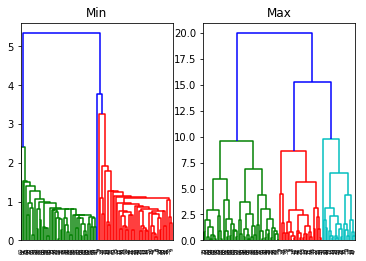

In [9]:
fig, axes = plt.subplots(1, 2)
tree_min = get_algomeration(X, measure=np.min)
tree_max = get_algomeration(X, measure=np.max)


dendrogram(tree_min.Z, ax=axes[0] )
dendrogram(tree_max.Z, ax=axes[1] )
axes[0].set_title("Min")
axes[1].set_title("Max")
plt.show()

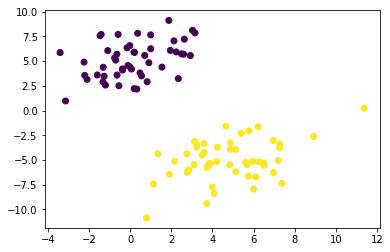

In [10]:
max_level=2
nodes, groups = tree_max.get_leafs_by_level(max_level)

data = np.array([node.pos for node in nodes])

plt.scatter(data[:,0], data[:,1], c=groups)
plt.show()

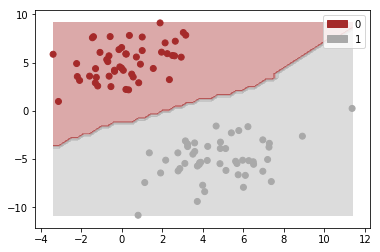

In [13]:
tree=tree_max
n_points=50

classes = np.unique(groups).tolist()

colors = np.random.choice(list(mcolors.CSS4_COLORS.keys()), size=len(classes), replace=False)
cm = LinearSegmentedColormap.from_list(
        'my_list', colors, N=len(classes))




xs_back = np.linspace(np.min(data[:,0]), np.max(data[:,0]), n_points)
ys_back = np.linspace(np.min(data[:,1]), np.max(data[:,1]), n_points)
xs_back, ys_back = np.meshgrid(xs_back, ys_back)
def get_zs_back(x, y):
    zs_back = np.zeros_like(x)
    
    for i in range(n_points):
        for j in range(n_points):
            x0 = x[i, j]
            y0 = y[i, j]
            pos = np.array([x0, y0])
            dists = []
            for i_node, node in enumerate(nodes):
                leafs_pos = [leaf.pos for leaf in tree.get_leafs(node)]
                dists.append(get_dist_sample([pos],leafs_pos ))
            i_min = np.argmin(dists)
            zs_back[i, j] = groups[i_min]
    return zs_back


zs_back = get_zs_back(xs_back, ys_back)            
plt.contourf(xs_back, ys_back, zs_back, alpha=0.4, cmap=cm)
data = np.array([node.pos for node in nodes])

plt.scatter(data[:,0], data[:,1], c=groups, cmap=cm)

legends = [
   mpatches.Patch(color=color, label=classe)
    for color, classe in zip(colors, classes)
] 
plt.legend(handles=legends)

In [14]:
def load_dataset(filename, train_size, y_col, features=None):
   
    
    with open(filename, 'r') as csvfile:
        lines = csv.reader(csvfile)
        x_train = []
        x_test = []
        y_train = []
        y_test = []
        for items in lines:
            
            if len(items)>1:
                y_val  = items[y_col]
                items.pop(y_col)
                if features is None:
                    items = np.array([float(item) for item in items])
                else:
                    items = np.array([float(items[i_feature]) for i_feature in features])
                if random.random() < train_size:
                    y_train.append(y_val)
                    x_train.append(items)
                else:
                    y_test.append(y_val)
                    x_test.append(items)
    return x_train, x_test, y_train, y_test

In [15]:
xs_train, xs_test, ys_train, ys_test = load_dataset(
            "iris.data.csv", 
            train_size=.9, 
            y_col=4)

In [16]:
classes = list(np.unique(ys_train))
classes_by_instance = [classes.index(val) for val in ys_train]

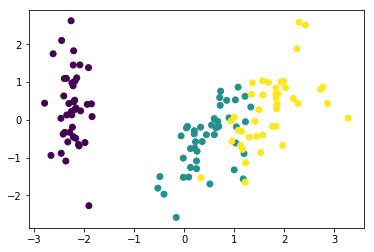

In [17]:
X_std =StandardScaler().fit_transform(xs_train)
sklearn_pca = sklearnPCA(n_components=2)

Y_sklearn = sklearn_pca.fit_transform(X_std)
plt.scatter(Y_sklearn[:,0], Y_sklearn[:,1], c=classes_by_instance)
    

In [18]:
list(np.unique(ys_train))

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

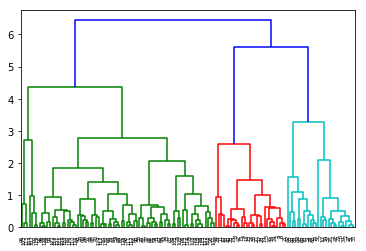

In [19]:
tree = get_algomeration(Y_sklearn, measure=np.max)

plt.figure()
dendrogram(tree.Z)
plt.show()

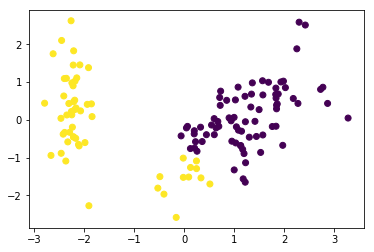

In [20]:
max_level=2
nodes, groups = tree.get_leafs_by_level(max_level)

data = np.array([node.pos for node in nodes])

plt.scatter(data[:,0], data[:,1], c=groups)
plt.show()

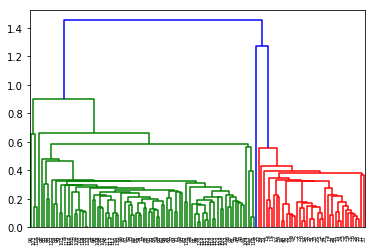

In [21]:
tree = get_algomeration(Y_sklearn, measure=np.min)

plt.figure()
dendrogram(tree.Z)
plt.show()

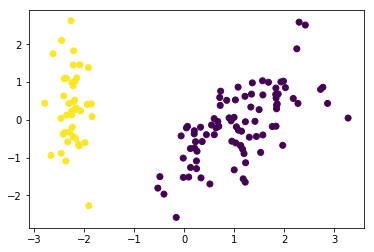

In [22]:
max_level=2
nodes, groups = tree.get_leafs_by_level(max_level)

data = np.array([node.pos for node in nodes])

plt.scatter(data[:,0], data[:,1], c=groups)
plt.show()